<a href="https://colab.research.google.com/github/raminnourizade/Proposal/blob/main/eeg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install mne

In [2]:
import gdown
import os
import numpy as np
import pandas as pd
import mne
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import glob
from sklearn.preprocessing import LabelBinarizer
import tensorflow as tf
import keras
from tensorflow.keras import layers
import sys
os.environ["TF_CPP_MIN_LOG_LEVEL"]="3"
import matplotlib.pyplot as plt



In [3]:
def load_data():
  path="dataset"
  if not os.path.exists(path):
      os.mkdir(path)
      print(f"Folder {path} created!")

      file_id = "1hG5v_COjPNzejRaL9XJAFERee9i2_V04"  # Replace this with your file's ID
      output_file = path+"/eeg.zip"  # Replace "data_file.ext" with the desired output filename and extension
      gdown.download(f"https://drive.google.com/uc?id={file_id}", output_file)
      !unzip "dataset/eeg.zip" -d "dataset"
      os.remove("dataset/eeg.zip")

  else:
      print(f"Folder {path} already exists")



  ds_dir = '/content/dataset/'
  scaler = StandardScaler()
  all_eeg=[]

  for (i, item) in enumerate(glob.glob(ds_dir + '*.edf')):
    print(item)
    raw = mne.io.read_raw_edf(item)
    # Filter EEG channels ('P3' and 'C3')
    eeg_channels = [ch for ch in raw.info['ch_names'] if ch in ['T3', 'T5', 'T4', 'T6']]
    if len(eeg_channels) != 4:
        print(f"Error: 'T3', 'T5', 'T4', 'T6' channels not found in {item}. Skipping...")
        continue

    # Create a new Raw object with only EEG channels
    raw = raw.copy().pick_channels(eeg_channels)

    # Apply bandpass filter (example: 0.1 Hz - 40 Hz)
    raw.load_data()  # Load the data into memory
    raw.filter(l_freq=0.1, h_freq=40)

    # Segment data into epochs (e.g., 1-second epochs)
    events = mne.make_fixed_length_events(raw, duration=1.0)
    epochs = mne.Epochs(raw, events, tmin=0, tmax=1.0, baseline=None)

    X = epochs.get_data()
    # Standardize features (Z-score normalization)
    n_samples, n_channels, n_time_points = X.shape

    # Reshape to 2D (n_samples x (n_channels * n_time_points))
    X_reshaped = X.reshape(n_samples, -1)
    # Apply StandardScaler
    X_scaled = scaler.fit_transform(X_reshaped)

    all_eeg.append(X_scaled)


  #all_eeg=np.array(all_eeg)

  lb=LabelBinarizer()
  all_labels = pd.read_excel("/content/dataset/states.xlsx",usecols=["status"])
  all_labels=lb.fit_transform(all_labels)

  X_train, X_test, y_train, y_test = train_test_split(all_eeg, all_labels, test_size=0.2, random_state=42)

  # Convert X_train and X_test to numpy arrays




  return  X_train, X_test, y_train, y_test, n_samples, n_channels ,n_time_points

In [ ]:
X_train, X_test, y_train, y_test, n_samples, n_channels ,n_time_points = load_data()


In [5]:
for x in range(len(X_train)):
  X_train[x]=X_train[x][0:1802,0:4883]

for x in range(len(X_test)):
  X_test[x]=X_test[x][0:1802,0:4883]



In [6]:
for x in range(len(X_train)):
  print(np.shape(X_train[x]))

(1802, 1028)
(1802, 1028)
(1802, 1028)
(1802, 1028)
(1802, 1028)
(1802, 1028)
(1802, 1028)
(1802, 1028)
(1802, 1028)
(1802, 1028)
(1802, 1028)
(1802, 1028)
(1802, 1028)
(1802, 1028)
(1802, 1028)
(1802, 1028)
(1802, 1028)
(1802, 1028)
(1802, 1028)
(1802, 1028)
(1802, 1028)


In [7]:
X_train=np.stack( X_train, axis=0 )
X_train = np.array(X_train)
#X_train_reshaped = X_train.reshape(len(X_train), n_channels, n_time_points, 1)

X_test=np.stack( X_test, axis=0 )
X_test = np.array(X_test)# Reshape the arrays
#X_test_reshaped = X_test.reshape(len(X_test), n_channels, n_time_points, 1)




In [8]:
def create_vit_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape, name="input_layer")

    # Data augmentation
    #augmented_inputs = data_augmentation(inputs)
    patch_size = 4 # 6
    # Patch creation
    patches = Patches(patch_size)(inputs)

    # Flatten patches
    flattened_patches = layers.Flatten()(patches)

    # MLP head
    mlp_output = layers.Dense(8, activation="relu")(flattened_patches)  # Reduced units
    mlp_output = layers.Dropout(0.1)(mlp_output)
    #mlp_output = mlp(flattened_patches, mlp_head_units, dropout_rate=0.1)


    # Classification head
    outputs = layers.Dense(num_classes, activation="softmax", name="output_layer")(mlp_output)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


In [9]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        input_shape = tf.shape(images)
        batch_size = input_shape[0]
        height = input_shape[1]
        width = input_shape[2]
        channels = input_shape[3]  # Assuming RGB images (3 channels)

        num_patches_h = height // self.patch_size
        num_patches_w = width // self.patch_size

        patches = tf.image.extract_patches(images, sizes=[1, self.patch_size, self.patch_size, 1], strides=[1, self.patch_size, self.patch_size, 1], rates=[1, 1, 1, 1], padding="VALID")
        patches = tf.reshape(patches, (batch_size, num_patches_h * num_patches_w, self.patch_size * self.patch_size * channels))

        return patches


In [10]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation="relu")(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


In [11]:
mlp_head_units =[64, 32]  ##[128, 64]  #  [256, 128]


In [20]:
#input_shape = (21, 1802, 514)
input_shape = (1802, 1028,1)

In [17]:
input_shape = X_train.shape[1:]

In [19]:
print("Shapes of training data and labels:")
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

print("Shapes of testing data and labels:")
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

Shapes of training data and labels:
X_train shape: (21, 1802, 1028)
y_train shape: (21, 1)
Shapes of testing data and labels:
X_test shape: (6, 1802, 1028)
y_test shape: (6, 1)


In [21]:
#input_shape = ( 21, 1802, 514)# (21,1802, 514) # (21,1805, 4883)
vit_model = create_vit_model(input_shape, 2)
vit_model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 1802, 1028, 1)]   0         
                                                                 
 patches_1 (Patches)         (None, 115650, 16)        0         
                                                                 
 flatten_1 (Flatten)         (None, 1850400)           0         
                                                                 
 dense_1 (Dense)             (None, 8)                 14803208  
                                                                 
 dropout_1 (Dropout)         (None, 8)                 0         
                                                                 
 output_layer (Dense)        (None, 2)                 18        
                                                                 
Total params: 14803226 (56.47 MB)
Trainable params: 1480322

In [22]:
vit_model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [23]:
history = vit_model.fit(X_train, y_train, batch_size=16, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
2/2 [==============================] - 3s 1s/step - loss: 4.4720 - accuracy: 0.5238 - val_loss: 23.9181 - val_accuracy: 0.6667
Epoch 2/10
2/2 [==============================] - 3s 2s/step - loss: 0.1250 - accuracy: 0.9048 - val_loss: 38.0141 - val_accuracy: 0.5000
Epoch 3/10
2/2 [==============================] - 2s 918ms/step - loss: 0.0330 - accuracy: 1.0000 - val_loss: 49.6534 - val_accuracy: 0.5000
Epoch 4/10
2/2 [==============================] - 2s 1s/step - loss: 2.5256 - accuracy: 0.9524 - val_loss: 50.8667 - val_accuracy: 0.5000
Epoch 5/10
2/2 [==============================] - 2s 844ms/step - loss: 0.0658 - accuracy: 1.0000 - val_loss: 51.7635 - val_accuracy: 0.5000
Epoch 6/10
2/2 [==============================] - 2s 1s/step - loss: 0.0329 - accuracy: 1.0000 - val_loss: 52.4875 - val_accuracy: 0.5000
Epoch 7/10
2/2 [==============================] - 2s 1s/step - loss: 0.7768 - accuracy: 0.9524 - val_loss: 55.5827 - val_accuracy: 0.5000
Epoch 8/10
2/2 [============

In [40]:
test_loss, test_accuracy = vit_model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

1/1 [==============================] - 0s 249ms/step - loss: 83.3597 - accuracy: 0.6667
Test Loss: 83.3597, Test Accuracy: 0.6667


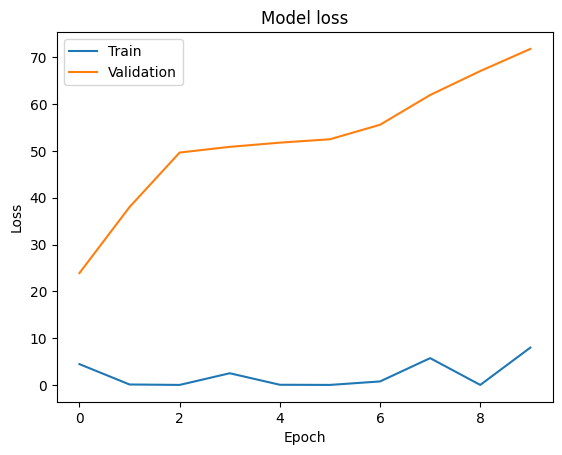

In [24]:
# Plot training & validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()